In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import scipy
from scipy import stats

In [93]:
df_pred = pd.read_csv('/hpc/compgen/projects/gw_cfdna/snv_qs/predict_cyclclean_with_lambdamodel/cycl_clean_predictions_scoreperread/cycl_predictions_properties_per_read.csv')
print(df_pred.shape)
print(list(df_pred.columns))

(313772, 6)
['region', 'pred-readid', 'pred-NM', 'pred-align_length', 'pred-cigar', 'pred-score']


In [94]:
df_cons = pd.read_csv('/hpc/compgen/projects/gw_cfdna/snv_qs/predict_cyclclean_with_lambdamodel/cycl_clean_consensus_scoreperread/cycl_clean_consensus_properties_per_read.csv')
# here, reads only with YM tag are in this csv
print(df_cons.shape)
print(list(df_cons.columns))
df_cons = df_cons[df_cons.region != 'region1' ]
print(list(df_cons.shape))

(443133, 9)
['region', 'cons-readid', 'cons-readid-short', 'cons-NM', 'cons-YM', 'cons-YR', 'cons-align_length', 'cons-cigar', 'cons-score']
[423880, 9]


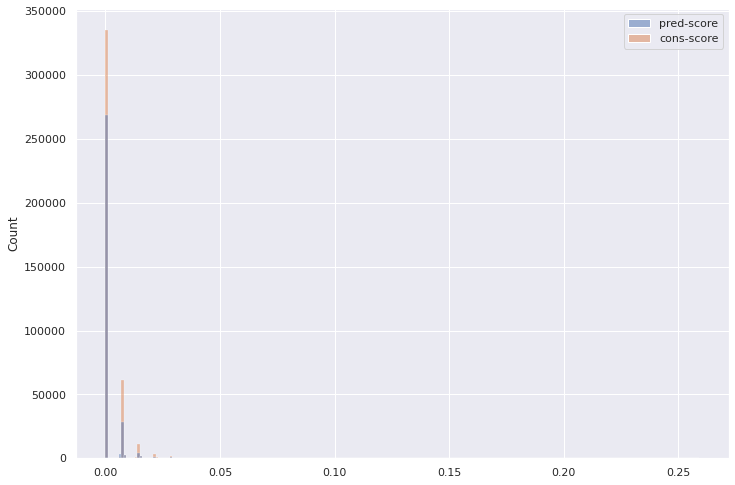

In [95]:
scores_pred = df_pred['pred-score']
scores_cons = df_cons['cons-score']
sns.histplot(data=[scores_pred, scores_cons], binwidth=0.001)
plt.show()

In [5]:
df_cons['region_readid'] = df_cons['region'] + '_' + df_cons['cons-readid-short']
df_pred['region_readid'] = df_pred['region'] + '_' + df_pred['pred-readid']

print(list(df_cons.columns))
print(list(df_pred.columns))

['region', 'cons-readid', 'cons-readid-short', 'cons-NM', 'cons-YM', 'cons-YR', 'cons-align_length', 'cons-cigar', 'cons-score', 'region_readid']
['region', 'pred-readid', 'pred-NM', 'pred-align_length', 'pred-cigar', 'pred-score', 'region_readid']


In [10]:
df_merged = df_cons.merge(df_pred, on='region_readid')
print(list(df_merged.columns))

print(df_cons.shape)
print(df_cons['cons-score'].mean())
print(df_pred.shape)
print(df_pred['pred-score'].mean())
print(df_merged.shape)

print(df_merged['pred-score'].mean())
print(df_merged['cons-score'].mean())


['region_x', 'cons-readid', 'cons-readid-short', 'cons-NM', 'cons-YM', 'cons-YR', 'cons-align_length', 'cons-cigar', 'cons-score', 'region_readid', 'region_y', 'pred-readid', 'pred-NM', 'pred-align_length', 'pred-cigar', 'pred-score']
(423880, 10)
0.0022272146922949283
(313772, 7)
0.0014008562547891997
(300123, 16)
0.0013823200889477134
0.0019200648852226423


In [9]:
df_cons_new = df_cons[['region_readid', 'cons-score']]  # select only two columns for a smaller dataframe
df_pred_new = df_pred[['region_readid', 'pred-score']]

df_cons_intersect = pd.merge(df_cons_new, df_pred_new["region_readid"], how = "inner")  # subset dataframe to only region_readid values that occur in other dataframe as well
print('consensus intersect shape: ', df_cons_intersect.shape)
df_pred_intersect = pd.merge(df_pred_new, df_cons_new["region_readid"], how = "inner")
print('prediction intersect shape: ', df_pred_intersect.shape)

df_joined = df_pred_intersect.merge(df_cons_intersect, left_on = 'region_readid', right_on = 'region_readid', how = "inner")   # merge dataframes so that for each readid_region, we have both scores

print('joined df shape: ', df_joined.shape)

# df_joined_nodups = df_joined.drop_duplicates()
# df_joined_nodups_readid = df_joined.drop_duplicates(subset='region_readid')

# print(len(df_cons_intersect[df_cons_intersect.duplicated()]))
# print(len(df_pred_intersect[df_pred_intersect.duplicated()]))
# print(len(df_joined_nodups[df_joined_nodups.duplicated()]))
# print(len(df_joined_nodups_readid[df_joined_nodups_readid.duplicated()]))
# print('unique region_read ids in joined df with duplicates removed: ',len(df_joined_nodups["region_readid"].unique()))

df_cons_intersect['type'] = 'cons'
df_pred_intersect['type'] = 'pred'

df_cons_intersect = df_cons_intersect.rename(columns = {'cons-score':'score'})
print(list(df_cons_intersect.columns))
print(df_cons_intersect.shape)
df_pred_intersect = df_pred_intersect.rename(columns = {'pred-score':'score'})
print(list(df_pred_intersect.columns))
print(df_pred_intersect.shape)

df_concat = pd.concat([df_cons_intersect, df_pred_intersect])
print(df_concat.shape)
print(list(df_concat.columns))
# print(df_concat.head)
print(df_concat.loc[df_concat['type'] == 'cons'].shape)
print(df_concat.loc[df_concat['type'] == 'pred'].shape)
print(df_concat.groupby('type').mean())

consensus intersect shape:  (300123, 2)
prediction intersect shape:  (300123, 2)
joined df shape:  (303091, 3)
['region_readid', 'score', 'type']
(300123, 3)
['region_readid', 'score', 'type']
(300123, 3)
(600246, 3)
['region_readid', 'score', 'type']
(300123, 3)
(300123, 3)
         score
type          
cons  0.001920
pred  0.001382


                                       region_readid     score  type
0       region2_5d8d32d1-7f72-4993-91b1-ed2441cbe0ca  0.007812  cons
1       region2_9b2b858d-3230-4928-b20d-874923f4fb14  0.007634  cons
2       region2_02ac6e90-8ae1-4b29-9ff3-164249badfce  0.007812  cons
3       region2_7652442c-45bd-5414-85d3-31384663c116  0.000000  cons
4       region2_554423fc-024b-5a8c-a6b9-e1f44e689c7f  0.007937  cons
...                                              ...       ...   ...
300118  region5_ecae0154-9a02-5531-bd22-903032b044ad  0.000000  pred
300119  region5_ad604060-c124-5fdb-9aa5-2bdde5518b66  0.000000  pred
300120  region5_01fc617a-7028-5428-962e-d971f47a7343  0.000000  pred
300121  region5_ff87abd2-5bb0-4592-affb-4db674942638  0.000000  pred
300122  region5_b7ddf53f-608b-4c43-8fa5-67a62ba7a769  0.000000  pred

[600246 rows x 3 columns]
(600246,)
(600246,)
cons v.s. pred: t-test paired samples with Bonferroni correction, P_val=0.000e+00 stat=4.637e+01


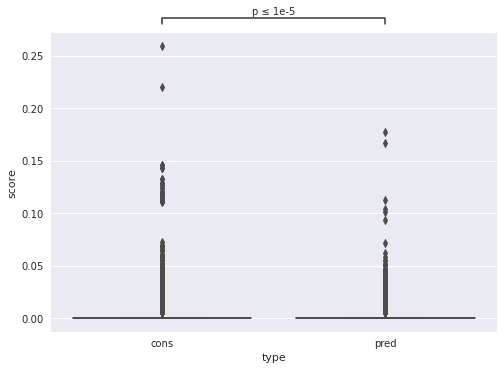

In [186]:

df = df_concat
print(df)
x = 'type'
y = 'score'
print(df[x].shape)
print(df[y].shape)
ax = sns.boxplot(data=df, x=x, y=y)
add_stat_annotation(ax, data=df, x=x, y=y, box_pairs = [('cons', 'pred')], test='t-test_paired', text_format='simple', loc='outside')
plt.show()

(300123, 16)
['region_x', 'cons-readid', 'cons-readid-short', 'cons-NM', 'cons-YM', 'cons-YR', 'cons-align_length', 'cons-cigar', 'cons-score', 'region_readid', 'region_y', 'pred-readid', 'pred-NM', 'pred-align_length', 'pred-cigar', 'pred-score']
(600246, 3)
shapiro test to test normality distrbution for consensus scores: ShapiroResult(statistic=0.4300832748413086, pvalue=0.0)
shapiro test to test normality distrbution for consensus scores: ShapiroResult(statistic=0.39362215995788574, pvalue=0.0)
both tests show a p-value < 0.05 so both datasets are not normally distributed. Instead of a paired t-test, we will perform the Wilcoxon Sign-Ranked test
Wilcoxon test on merged dataframe:
WilcoxonResult(statistic=1040453317.0, pvalue=0.0)
0.0013823200889477134
0.0019200648852226423
         score
type          
cons  0.001920
pred  0.001382


/hpc/compgen/users/idenhond/miniconda/envs/nanopore_snv/lib/python3.8/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Using zero_method  wilcox
cons v.s. pred: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.259e-125 stat=1.881e+09


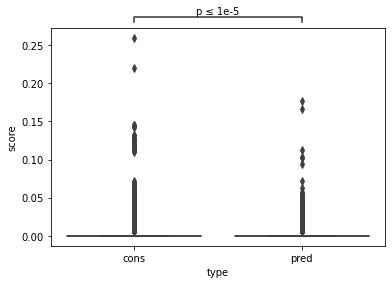

In [15]:
print(df_merged.shape)
print(list(df_merged.columns))

print(df_concat.shape)
print(f'shapiro test to test normality distrbution for consensus scores: {stats.shapiro(df_merged["cons-score"])}')    # this value is lower than 0.05 = significant = there is no normal distribution
print(f'shapiro test to test normality distrbution for consensus scores: {stats.shapiro(df_merged["pred-score"])}')    # this value is lower than 0.05 = significant = there is no normal distribution
print('both tests show a p-value < 0.05 so both datasets are not normally distributed. Instead of a paired t-test, we will perform the Wilcoxon Sign-Ranked test')


print('Wilcoxon test on merged dataframe:')
print(stats.wilcoxon(df_merged['pred-score'], df_merged['cons-score']))
print(df_merged['pred-score'].mean())
print(df_merged['cons-score'].mean())
print(df_concat.groupby('type').mean())

plt.figure(4)
ax = sns.boxplot(data=df_concat, x='type', y='score')
add_stat_annotation(ax, data=df_concat, x='type', y='score', box_pairs = [('cons', 'pred')], test='Wilcoxon', text_format='simple', loc='outside')
plt.show()
